In [18]:
import re, sys, os
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
import warnings
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import rdChemReactions, AllChem, Draw, PandasTools
from torch.utils.data import Dataset, DataLoader

RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Transform

In [2]:
df_mols = pd.read_pickle("../data/transformed/df_mols_ready.pkl")

In [3]:
df_mols['bbs_smi'] = df_mols['A_smi'] + '.' + df_mols['B_smi'] + '.' + df_mols['C_smi']

#### Encode/decode

In [9]:
special_tokens = ["<pad>", "<s>", "</s>"]

all_smiles = df_mols['mol_smi'].tolist() + df_mols['bbs_smi'].tolist()
chars = set("".join(all_smiles))
itos = special_tokens + sorted(list(chars))   # index-to-string
stoi = {ch: i for i, ch in enumerate(itos)}   # string-to-index
pad_id = stoi["<pad>"]

def encode(smiles, stoi, max_len=128):
    # returns list of token IDs with <s> at start, </s> at end, padded
    ids = [stoi["<s>"]] + [stoi[ch] for ch in smiles] + [stoi["</s>"]]
    if len(ids) < max_len:
        ids += [stoi["<pad>"]] * (max_len - len(ids))
    return ids[:max_len]

def decode(ids, itos):
    # returns string ignoring special tokens
    chars = [itos[i] for i in ids if itos[i] not in ("<pad>", "<s>", "</s>")]
    return "".join(chars)

In [10]:
def encode_target(smi, stoi, max_len=128):
    full_ids = encode(smi, stoi, max_len)   # <s> ... </s> + pad
    tgt_in = full_ids[:-1]                  # decoder input (drop final </s>)
    tgt_out = full_ids[1:]                  # loss target (drop initial <s>)
    return tgt_in, tgt_out

# Apply to dataframe
df_mols['tgt_in'], df_mols['tgt_out'] = zip(*df_mols['bbs_smi'].apply(lambda x: encode_target(x, stoi)))

In [12]:
def decode_show_special(ids, itos):
    chars = [itos[i] for i in ids]  # do NOT filter
    return "".join(chars)

In [13]:
class MolDataset(Dataset):
    def __init__(self, df, stoi, max_len=128):
        self.src = [encode(s, stoi, max_len) for s in df['mol_smi']]
        self.tgt_in = df['tgt_in'].tolist()
        self.tgt_out = df['tgt_out'].tolist()
    def __len__(self):
        return len(self.src)
    def __getitem__(self, idx):
        return torch.tensor(self.src[idx]), torch.tensor(self.tgt_in[idx]), torch.tensor(self.tgt_out[idx])

In [14]:
# Step 2a: Split dataframe into train/validation
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_mols, test_size=0.2, random_state=42)

# Step 3: Create datasets
train_dataset = MolDataset(df_train, stoi)
val_dataset   = MolDataset(df_val, stoi)

# Step 4: Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)

In [15]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model=384, n_layers=2, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.rnn = nn.GRU(d_model, d_model, num_layers=n_layers, batch_first=True, dropout=dropout)
    def forward(self, x):
        x = self.emb(x)
        out, h = self.rnn(x)
        return out, h

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model=384, n_layers=2, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.rnn = nn.GRU(d_model, d_model, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.proj = nn.Linear(d_model, vocab_size)
    def forward(self, y_in, h):
        y = self.emb(y_in)
        out, h = self.rnn(y, h)
        logits = self.proj(out)
        return logits, h

class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, d_model=384, n_layers=2, dropout=0.1):
        super().__init__()
        self.enc = Encoder(vocab_size, d_model, n_layers, dropout)
        self.dec = Decoder(vocab_size, d_model, n_layers, dropout)
    def forward(self, src, tgt_in):
        _, h = self.enc(src)
        logits, _ = self.dec(tgt_in, h)
        return logits


In [16]:
vocab_size = len(stoi)
model = Seq2Seq(vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)  # ignore padding in loss

In [20]:
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt_in, tgt_out in loader:
            src, tgt_in, tgt_out = src.to(device), tgt_in.to(device), tgt_out.to(device)
            logits = model(src, tgt_in)
            loss = criterion(logits.view(-1, logits.size(-1)), tgt_out.view(-1))
            total_loss += loss.item() * src.size(0)
    return total_loss / len(loader.dataset)

In [30]:
n_epochs = 30
checkpoint_path = "../models/seq2seq_gru_bbs.pt"

# --- Resume from checkpoint if exists
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming from epoch {start_epoch}")

Resuming from epoch 90


In [ ]:
# --- Training loop
for epoch in range(start_epoch, start_epoch+n_epochs):
    model.train()
    total_train_loss = 0

    for src, tgt_in, tgt_out in train_loader:
        src, tgt_in, tgt_out = src.to(device), tgt_in.to(device), tgt_out.to(device)
        optimizer.zero_grad()
        logits = model(src, tgt_in)
        loss = criterion(logits.view(-1, logits.size(-1)), tgt_out.view(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * src.size(0)

    train_loss = total_train_loss / len(train_loader.dataset)
    
    # --- Compute validation loss
    val_loss = validate(model, val_loader, criterion, device)
    
    # --- Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_path)
    
    print(f"Epoch {epoch:02d} | train loss {train_loss:.4f} | val loss {val_loss:.4f}")

In [28]:
def predict_bbs(model, src_smiles, stoi, itos, max_len=128, device=device):
    model.eval()
    src_ids = torch.tensor([encode(src_smiles, stoi, max_len)]).to(device)
    
    # --- Encode once
    _, h = model.enc(src_ids)
    
    # --- Decoder starts with <s>
    tgt_ids = torch.tensor([[stoi["<s>"]]], device=device)
    pred_tokens = []

    for _ in range(max_len):
        logits, h = model.dec(tgt_ids, h)
        next_token = logits[:, -1, :].argmax(-1, keepdim=True)
        if next_token.item() == stoi["</s>"]:
            break
        pred_tokens.append(next_token.item())
        tgt_ids = torch.cat([tgt_ids, next_token], dim=1)

    pred_bbs = "".join([itos[i] for i in pred_tokens])
    return pred_bbs

In [ ]:
for i in range(3):
    mol_smi = df_mols['mol_smi'].iloc[i]
    true_bbs = df_mols['bbs_smi'].iloc[i]
    pred_bbs = predict_bbs(model, mol_smi, stoi, itos)
    print(f"MOL  : {mol_smi}")
    print(f"TRUE : {true_bbs}")
    print(f"PRED : {pred_bbs}\n")

In [31]:
def mol_to_image(smiles, size=(200,200)):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return Draw.MolToImage(mol, size=size)


In [33]:
df_val.shape

(150, 11)

In [34]:
df_test = df_val.head(10)

In [38]:
rows = []
for i in range(len(df_test)):
    mol_smi = df_test['mol_smi'].iloc[i]
    true_bbs = df_test['bbs_smi'].iloc[i]
    pred_bbs = predict_bbs(model, mol_smi, stoi, itos)
    
    rows.append({
        'Molecule': mol_to_image(mol_smi),
        'True BBS': mol_to_image(true_bbs.split('.')[0]),  # optionally only first fragment
        'Pred BBS': mol_to_image(pred_bbs.split('.')[0])
    })

df_vis = pd.DataFrame(rows)
df_test

,mol_smi,mol_id,A_id,B_id,C_id,A_smi,B_smi,C_smi,bbs_smi,tgt_in,tgt_out
507,COc1cccc(F)c1[C@@H]1C[C@H](Cl)C(=O)N1Cc1cccc(O...,508,A2,B4,C78,[*]c1c(F)cccc1OC,[*][C@]1([H])C[C@]([H])(Cl)C(=O)N1[*],[*]Cc1cccc(OC(F)(F)C(F)F)c1,[*]c1c(F)cccc1OC.[*][C@]1([H])C[C@]([H])(Cl)C(...,"[1, 23, 6, 24, 25, 10, 25, 4, 18, 5, 25, 25, 2...","[23, 6, 24, 25, 10, 25, 4, 18, 5, 25, 25, 25, ..."
358,COc1cccc(OC)c1[C@@H]1CCCC(=O)N1Cc1cccc(-n2nccn...,359,A1,B8,C68,[*]c1c(OC)cccc1OC,[*][C@]1([H])CCCC(=O)N1[*],[*]Cc1cccc(-n2nccn2)c1,[*]c1c(OC)cccc1OC.[*][C@]1([H])CCCC(=O)N1[*].[...,"[1, 23, 6, 24, 25, 10, 25, 4, 21, 17, 5, 25, 2...","[23, 6, 24, 25, 10, 25, 4, 21, 17, 5, 25, 25, ..."
133,COc1cccc(OC)c1[C@@H]1[C@@H](C(=O)O)CCC(=O)N1Cc...,134,A1,B55,C1,[*]c1c(OC)cccc1OC,[*][C@@]1([H])N([*])C(=O)CC[C@]1([H])C(=O)O,[*]Cc1ccc(OC(F)(F)F)cc1,[*]c1c(OC)cccc1OC.[*][C@@]1([H])N([*])C(=O)CC[...,"[1, 23, 6, 24, 25, 10, 25, 4, 21, 17, 5, 25, 2...","[23, 6, 24, 25, 10, 25, 4, 21, 17, 5, 25, 25, ..."
251,COc1cccc(OC)c1[C@@H]1C[C@H](C)C(=O)N1Cc1cccc(-...,252,A1,B7,C93,[*]c1c(OC)cccc1OC,[*][C@]1([H])C[C@]([H])(C)C(=O)N1[*],[*]Cc1cccc(-n2cccn2)n1,[*]c1c(OC)cccc1OC.[*][C@]1([H])C[C@]([H])(C)C(...,"[1, 23, 6, 24, 25, 10, 25, 4, 21, 17, 5, 25, 2...","[23, 6, 24, 25, 10, 25, 4, 21, 17, 5, 25, 25, ..."
300,C[C@H]1C[C@@H](c2c(O)cccc2F)N(Cc2ccc(OC(F)(F)F...,301,A49,B7,C1,[*]c1c(O)cccc1F,[*][C@]1([H])C[C@]([H])(C)C(=O)N1[*],[*]Cc1ccc(OC(F)(F)F)cc1,[*]c1c(O)cccc1F.[*][C@]1([H])C[C@]([H])(C)C(=O...,"[1, 23, 6, 24, 25, 10, 25, 4, 21, 5, 25, 25, 2...","[23, 6, 24, 25, 10, 25, 4, 21, 5, 25, 25, 25, ..."
681,CCOc1ccc(F)c(F)c1[C@@H]1C[C@@H](O)C(=O)N1Cc1cc...,682,A87,B5,C1,[*]c1c(OCC)ccc(F)c1F,[*][C@]1([H])C[C@@]([H])(O)C(=O)N1[*],[*]Cc1ccc(OC(F)(F)F)cc1,[*]c1c(OCC)ccc(F)c1F.[*][C@]1([H])C[C@@]([H])(...,"[1, 23, 6, 24, 25, 10, 25, 4, 21, 17, 17, 5, 2...","[23, 6, 24, 25, 10, 25, 4, 21, 17, 17, 5, 25, ..."
337,COc1cccc(OC)c1[C@@H]1CCCCC(=O)N1Cc1cccc(-c2cnc...,338,A1,B16,C76,[*]c1c(OC)cccc1OC,[*][C@]1([H])CCCCC(=O)N1[*],[*]Cc1cccc(-c2cncs2)c1,[*]c1c(OC)cccc1OC.[*][C@]1([H])CCCCC(=O)N1[*]....,"[1, 23, 6, 24, 25, 10, 25, 4, 21, 17, 5, 25, 2...","[23, 6, 24, 25, 10, 25, 4, 21, 17, 5, 25, 25, ..."
155,COc1cccc(OC)c1[C@@H]1CCCC(=O)N1Cc1cn2ccccc2n1,156,A1,B8,C53,[*]c1c(OC)cccc1OC,[*][C@]1([H])CCCC(=O)N1[*],[*]Cc1cn2ccccc2n1,[*]c1c(OC)cccc1OC.[*][C@]1([H])CCCC(=O)N1[*].[...,"[1, 23, 6, 24, 25, 10, 25, 4, 21, 17, 5, 25, 2...","[23, 6, 24, 25, 10, 25, 4, 21, 17, 5, 25, 25, ..."
529,COc1ccc2c(c1[C@@H]1CCCC(=O)N1Cc1ccc(OC(F)(F)F)...,530,A57,B8,C1,[*]c1c(OC)ccc2c1OCO2,[*][C@]1([H])CCCC(=O)N1[*],[*]Cc1ccc(OC(F)(F)F)cc1,[*]c1c(OC)ccc2c1OCO2.[*][C@]1([H])CCCC(=O)N1[*...,"[1, 23, 6, 24, 25, 10, 25, 4, 21, 17, 5, 25, 2...","[23, 6, 24, 25, 10, 25, 4, 21, 17, 5, 25, 25, ..."
737,COc1cccc(OCC(F)F)c1[C@H]1C[C@H](O)C(=O)N1Cc1cc...,738,A60,B67,C2,[*]c1c(OC)cccc1OCC(F)F,[*][C@@]1([H])C[C@]([H])(O)C(=O)N1[*],[*]Cc1ccc2oc3ccccc3c2c1,[*]c1c(OC)cccc1OCC(F)F.[*][C@@]1([H])C[C@]([H]...,"[1, 23, 6, 24, 25, 10, 25, 4, 21, 17, 5, 25, 2...","[23, 6, 24, 25, 10, 25, 4, 21, 17, 5, 25, 25, ..."


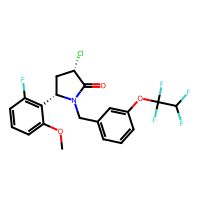

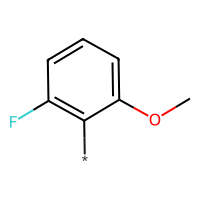

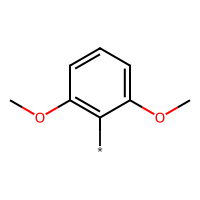

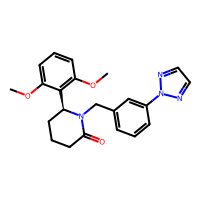

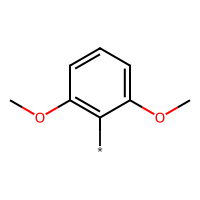

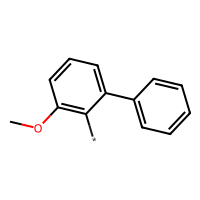

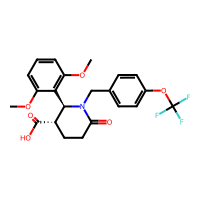

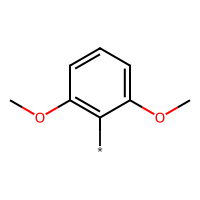

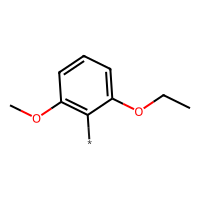

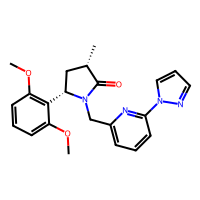

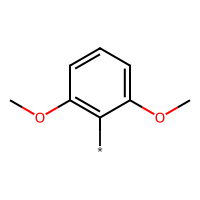

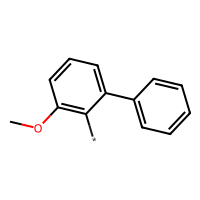

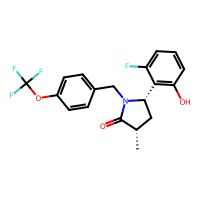

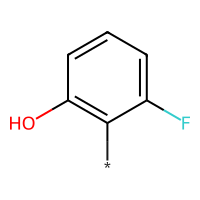

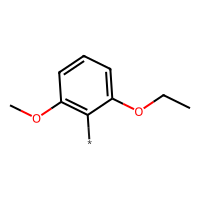

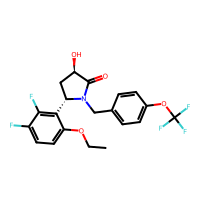

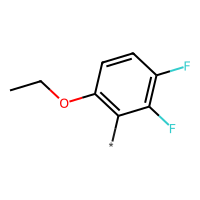

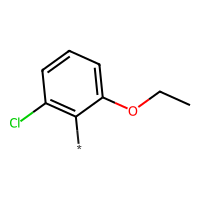

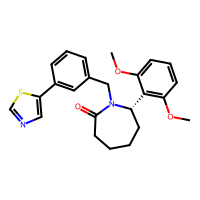

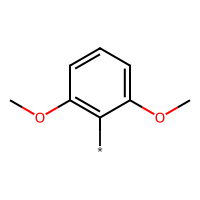

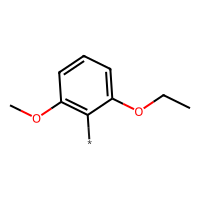

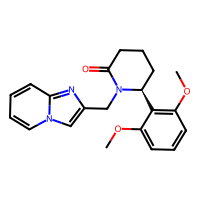

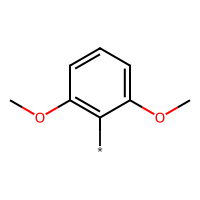

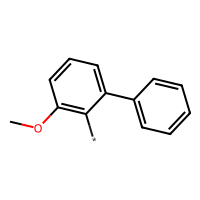

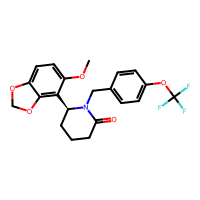

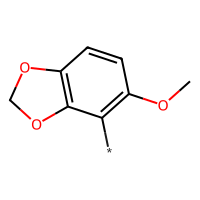

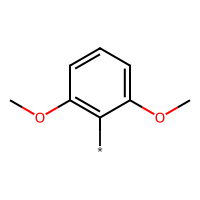

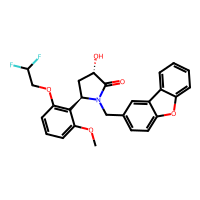

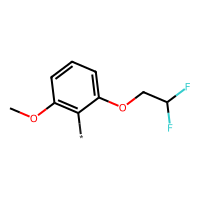

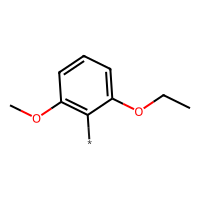

In [36]:
from IPython.display import display
for i, row in df_vis.iterrows():
    display(row['Molecule'])
    display(row['True BBS'])
    display(row['Pred BBS'])
